In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataclasses import dataclass



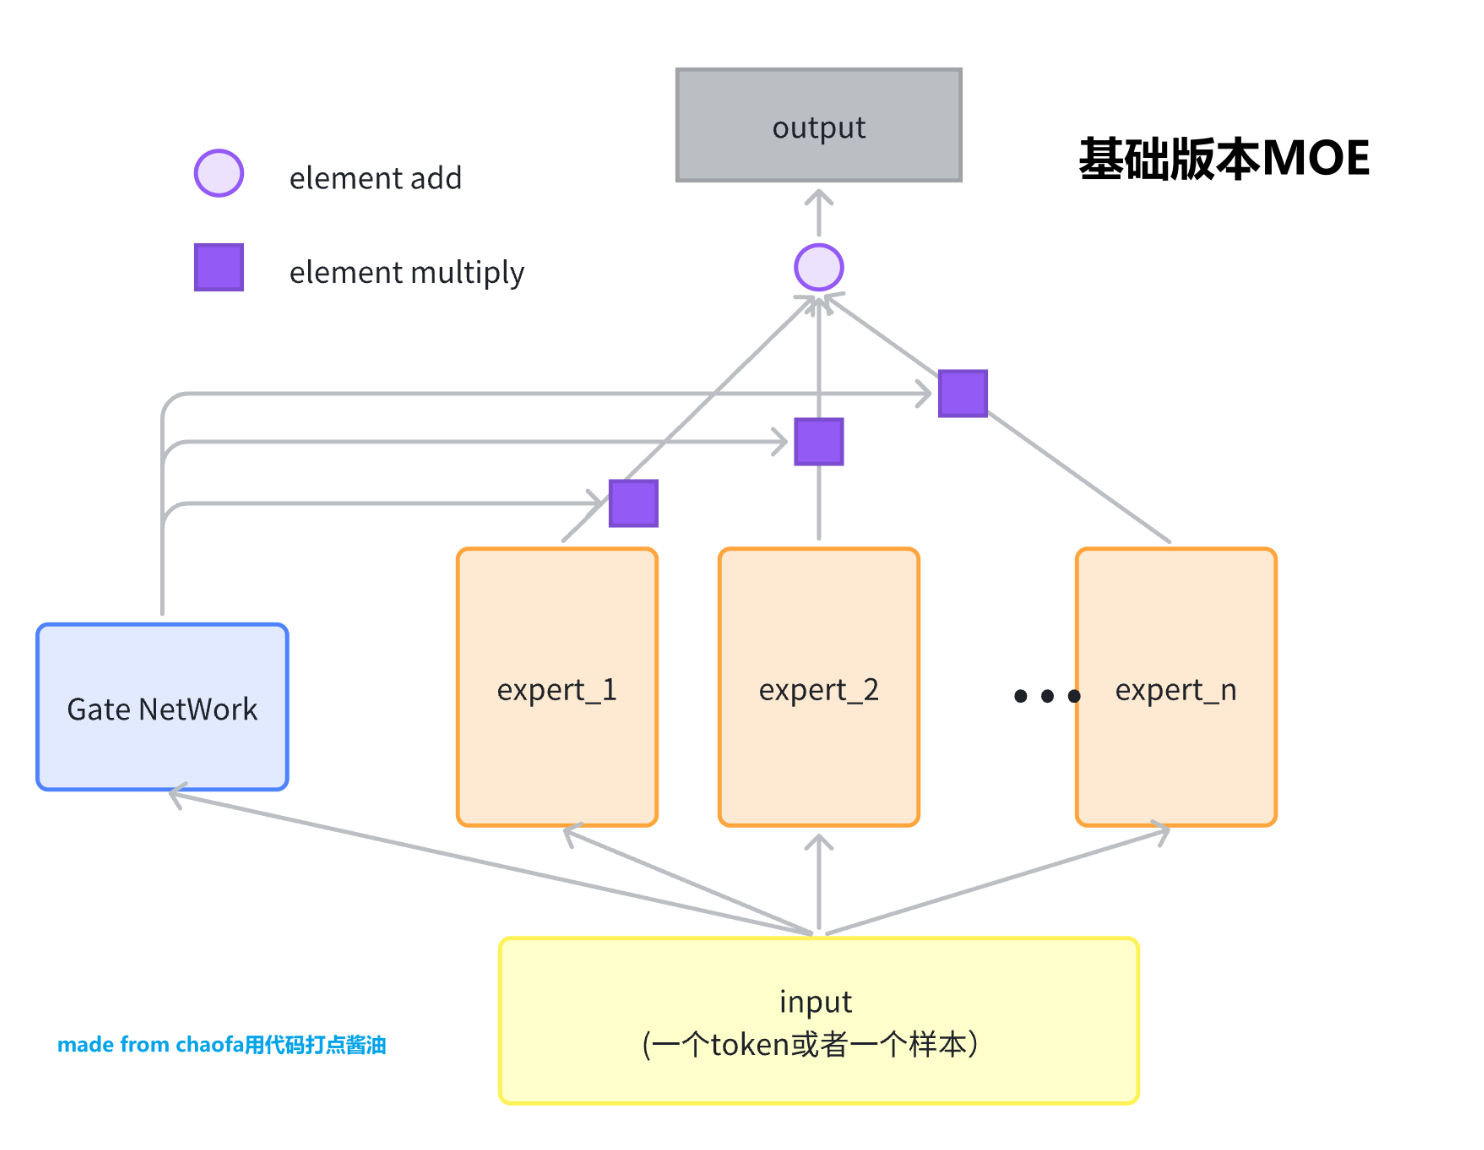

In [4]:
from IPython.display import Image, display
display(Image(filename="../markdown/assets/basic_moe.png"))

In [5]:
# 基本的专家映射模型    选择了线性映射
class BaseExpert(nn.Module):
    def __init__(self, feature_in,feature_out):
        super().__init__()
        self.expert = nn.Linear(feature_in,feature_out)

    def forward(self,x):
        return self.expert(x)

class BaseMoe(nn.Module):
    def __init__(self,feature_in,feature_out,expert_num):
        super().__init__()
        # 循环迭代创建专家
        self.expert = nn.ModuleList([
            BaseExpert(feature_in,feature_out) for _ in range(expert_num)
        ]
        )

        # 每一个专家所占的权重
        self.gate = nn.Linear(feature_in,expert_num)

    def forward(self,x):
        # 创建专家的权重
        # shape(batch,expert_num)
        gate = self.gate(x)

        # 循环创建不同的专家 ps:torch.cat 和 torch.concat 相同，cat老版本先出现，兼容性高
        # 需要对创建的所有专家进行拼接，所以需要开创第二个维度，然后才可以拼接
        # experts -> (batch,feature_out)  to (batch,1,feature_out) to (batch,expert_num,feature_out)
        experts = torch.cat([
            experts(x).unsqueeze(1) for experts in self.expert],
            dim=1
        )
        # 对gate进行增加维度 才可以进行矩阵相乘
        # gate -> (batch,1,expert_num)
        gate = gate.unsqueeze(1)

        # 最终的输出为:(batch,feature_out)
        # 这里的output为(batch,1,feature_out) 需要再进行去除维度
        output = gate @ experts

        return output.squeeze(1)
    
def test_basic_moe():
    x = torch.rand(2, 4)

    basic_moe = BaseMoe(4, 3, 2)
    out = basic_moe(x)
    print(out)
    print(out.shape)


test_basic_moe()

tensor([[ 0.0563, -0.1664, -0.1318],
        [ 0.2988, -0.0083,  0.2003]], grad_fn=<SqueezeBackward1>)
torch.Size([2, 3])


## 2. Sparse Moe


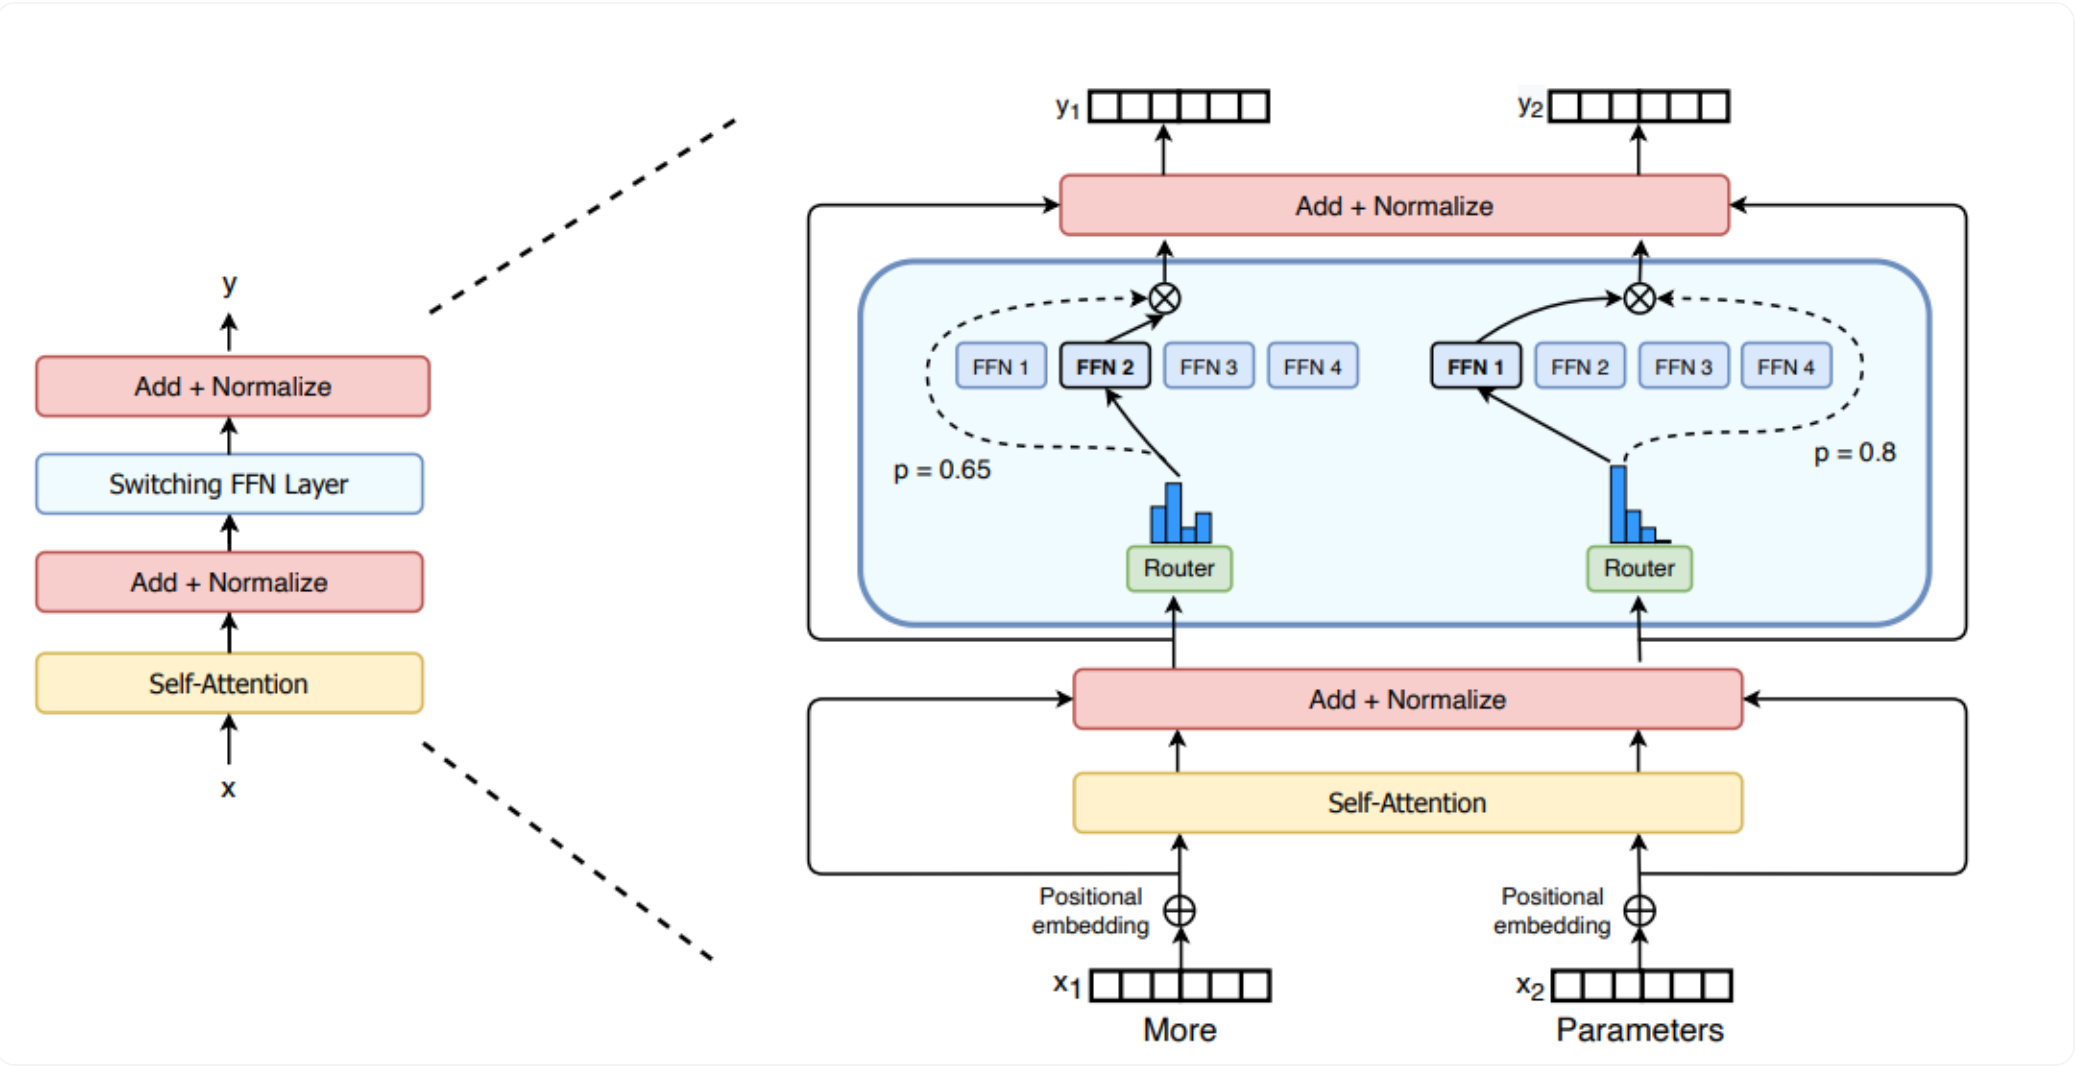

In [6]:
from IPython.display import Image, display
display(Image(filename="../markdown/assets/switch-transformers-moe-model.png"))

计算gate的topk,然后onehot topk,之后选择对应权重相乘

In [ ]:

class Moeconfig():
    def __init__(self,hidden_dim,expert_num,topk,select_expert=None):
        self.hidden_dim = hidden_dim
        self.expert_num = expert_num
        self.topk = topk
        self.select_expert = select_expert
    
    def forward():
        pass
class RouterMoe(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.topk = config.topk
        # 创建gate 获取概率
        self.gate = nn.Linear(config.hidden_dim,config.expert_num)
    
    def forward(self,x):
        # x shape(batch * seq , hidden_dim)
        gate = self.gate(x)

        # 计算概率 , 最后一个维度 shape(batch * seq, expert_num) 
        logists_gate = F.softmax(gate,dim=-1,dtype=torch.float)
        
        # 选取最高概率的expert,输出的维度为(batch * seq , top_k)
        select_weight , select_mask = torch.topk(logists_gate,self.topk,dim=-1)
        
        # 对选取的权重进行归一化，保持维度不变
        select_weight = select_weight / select_weight.sum(dim=-1,keepdim=True)
        select_weight = select_weight.to(x.dtype)

        # 创建one hot , 总编码数量为 专家数量
        # shape (batch * seq , top_k , expert_num)
        one_hot_mask = F.one_hot(select_mask,self.config.expert_num)

        # 对该矩阵进行shape变换(expert_num,top_k, batch * seq)
        one_hot_mask = one_hot_mask.permute(2,1,0)
        
        return gate,select_weight,select_mask,one_hot_mask



class SparseMoe(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.routemoe = RouterMoe(config)
        self.expert_layer = nn.ModuleList([
            BaseMoe(config.hidden_dim,config.hidden_dim,config.expert_num) for _ in range(config.expert_num)
        ])

    def forward(self,x):
        # 先要变换x shape，然后才能输入进router moe中
        batch , seq , hidden_dim = x.size()
        x = x.view(-1,hidden_dim)
        
        logistis,select_weight,select_mask,one_hot_mask = self.routemoe(x)

        # 创建一个和原矩阵相同的矩阵用于接收数据,需要注意指定device
        final = torch.zeros((batch * seq,hidden_dim),dtype=x.dtype,device=x.device)

        # 遍历每一个专家
        for expert_id in range(self.config.expert_num):
            # 第几个专家
            # 表示每个专家的映射
            expert = self.expert_layer[expert_id]

            # 获取当前tokens对应专家和topk
            # one_hot_mask 的 shape 是(experts_num,topk,batch * seq)
            # one_hot_mask[expert_id] 是 当前专家下，top_k 下，被选择的 tokens 的 0-1矩阵
            topk,tokens_id = torch.where(one_hot_mask[expert_id])

            # where获取到的topk 和tokens_id 对应了矩阵中 非零的坐标的横坐标和纵坐标。
            # 假设topk有5个，则其取值范围就是0-4 对应了top几
            # tokens_id 为batch_size * seq 其取值范围就是对应了其 不同的tokens

            # 现在要获取 有多少tokens是经过这个专家的
            # 注意！！这里unsqueeze只是为了增加兼容性 shape(1,tokens_di,hidden_dim)
            change_tokens = x.unsqueeze(0)[:,tokens_id,:].reshape(-1,hidden_dim)

            # 二者权重相乘 
            # select_weight shape (batch * seq , topk)
            # 选择完tokens和topk之后，维度就变成(select_tokens,) 要进行相乘需要继续增加一个维度
            weight = select_weight[tokens_id,topk].unsqueeze(-1)

            #  expert(change_tokens) 指的是把当前选中的tokens放到 神经网络中进行映射
            data = expert(change_tokens)
            
            # 把输入数据和权重相乘 得到最终结果
            result = weight * data

            # 把数据加到final数组中
            # index_add_(维度，索引，值) 原地操作相加，比数组索引final[tokens_id] += reslut速度来的要快，因为这个需要频繁访问内存
            final.index_add_(0,tokens_id,result.to(x.dtype))
        # 还原成原来的数据格式
        final = final.reshape(batch,seq,hidden_dim)
        # logistis 是用于平衡专家负载均衡
        return final,logistis

def test_sparse_moe():
    x = torch.rand(3,400,100)
    config = Moeconfig(100,3,2)
    model = SparseMoe(config)
    reslut,lologistis = model(x)
    print(x)
    print(reslut)
    print(reslut.shape)
test_sparse_moe()


tensor([[[0.3299, 0.0222, 0.5330,  ..., 0.8108, 0.1122, 0.7856],
         [0.6838, 0.4725, 0.3472,  ..., 0.3740, 0.5044, 0.3976],
         [0.9095, 0.8095, 0.3758,  ..., 0.5867, 0.7030, 0.2989],
         ...,
         [0.8212, 0.9585, 0.9199,  ..., 0.6792, 0.5853, 0.6225],
         [0.8999, 0.7705, 0.0861,  ..., 0.8584, 0.2655, 0.2252],
         [0.5945, 0.0100, 0.3193,  ..., 0.3909, 0.1796, 0.8106]],

        [[0.5326, 0.8749, 0.3667,  ..., 0.8003, 0.7793, 0.5882],
         [0.3383, 0.3725, 0.1812,  ..., 0.3779, 0.3250, 0.2913],
         [0.5999, 0.3716, 0.1842,  ..., 0.4122, 0.8294, 0.6442],
         ...,
         [0.7122, 0.5812, 0.5186,  ..., 0.8677, 0.0519, 0.0633],
         [0.3266, 0.9448, 0.2939,  ..., 0.1257, 0.2737, 0.8057],
         [0.7690, 0.7557, 0.7069,  ..., 0.2496, 0.9759, 0.2649]],

        [[0.6707, 0.8174, 0.2706,  ..., 0.5490, 0.5434, 0.7926],
         [0.3752, 0.1008, 0.8732,  ..., 0.2839, 0.8800, 0.0277],
         [0.9191, 0.2289, 0.5001,  ..., 0.8196, 0.4140, 0.

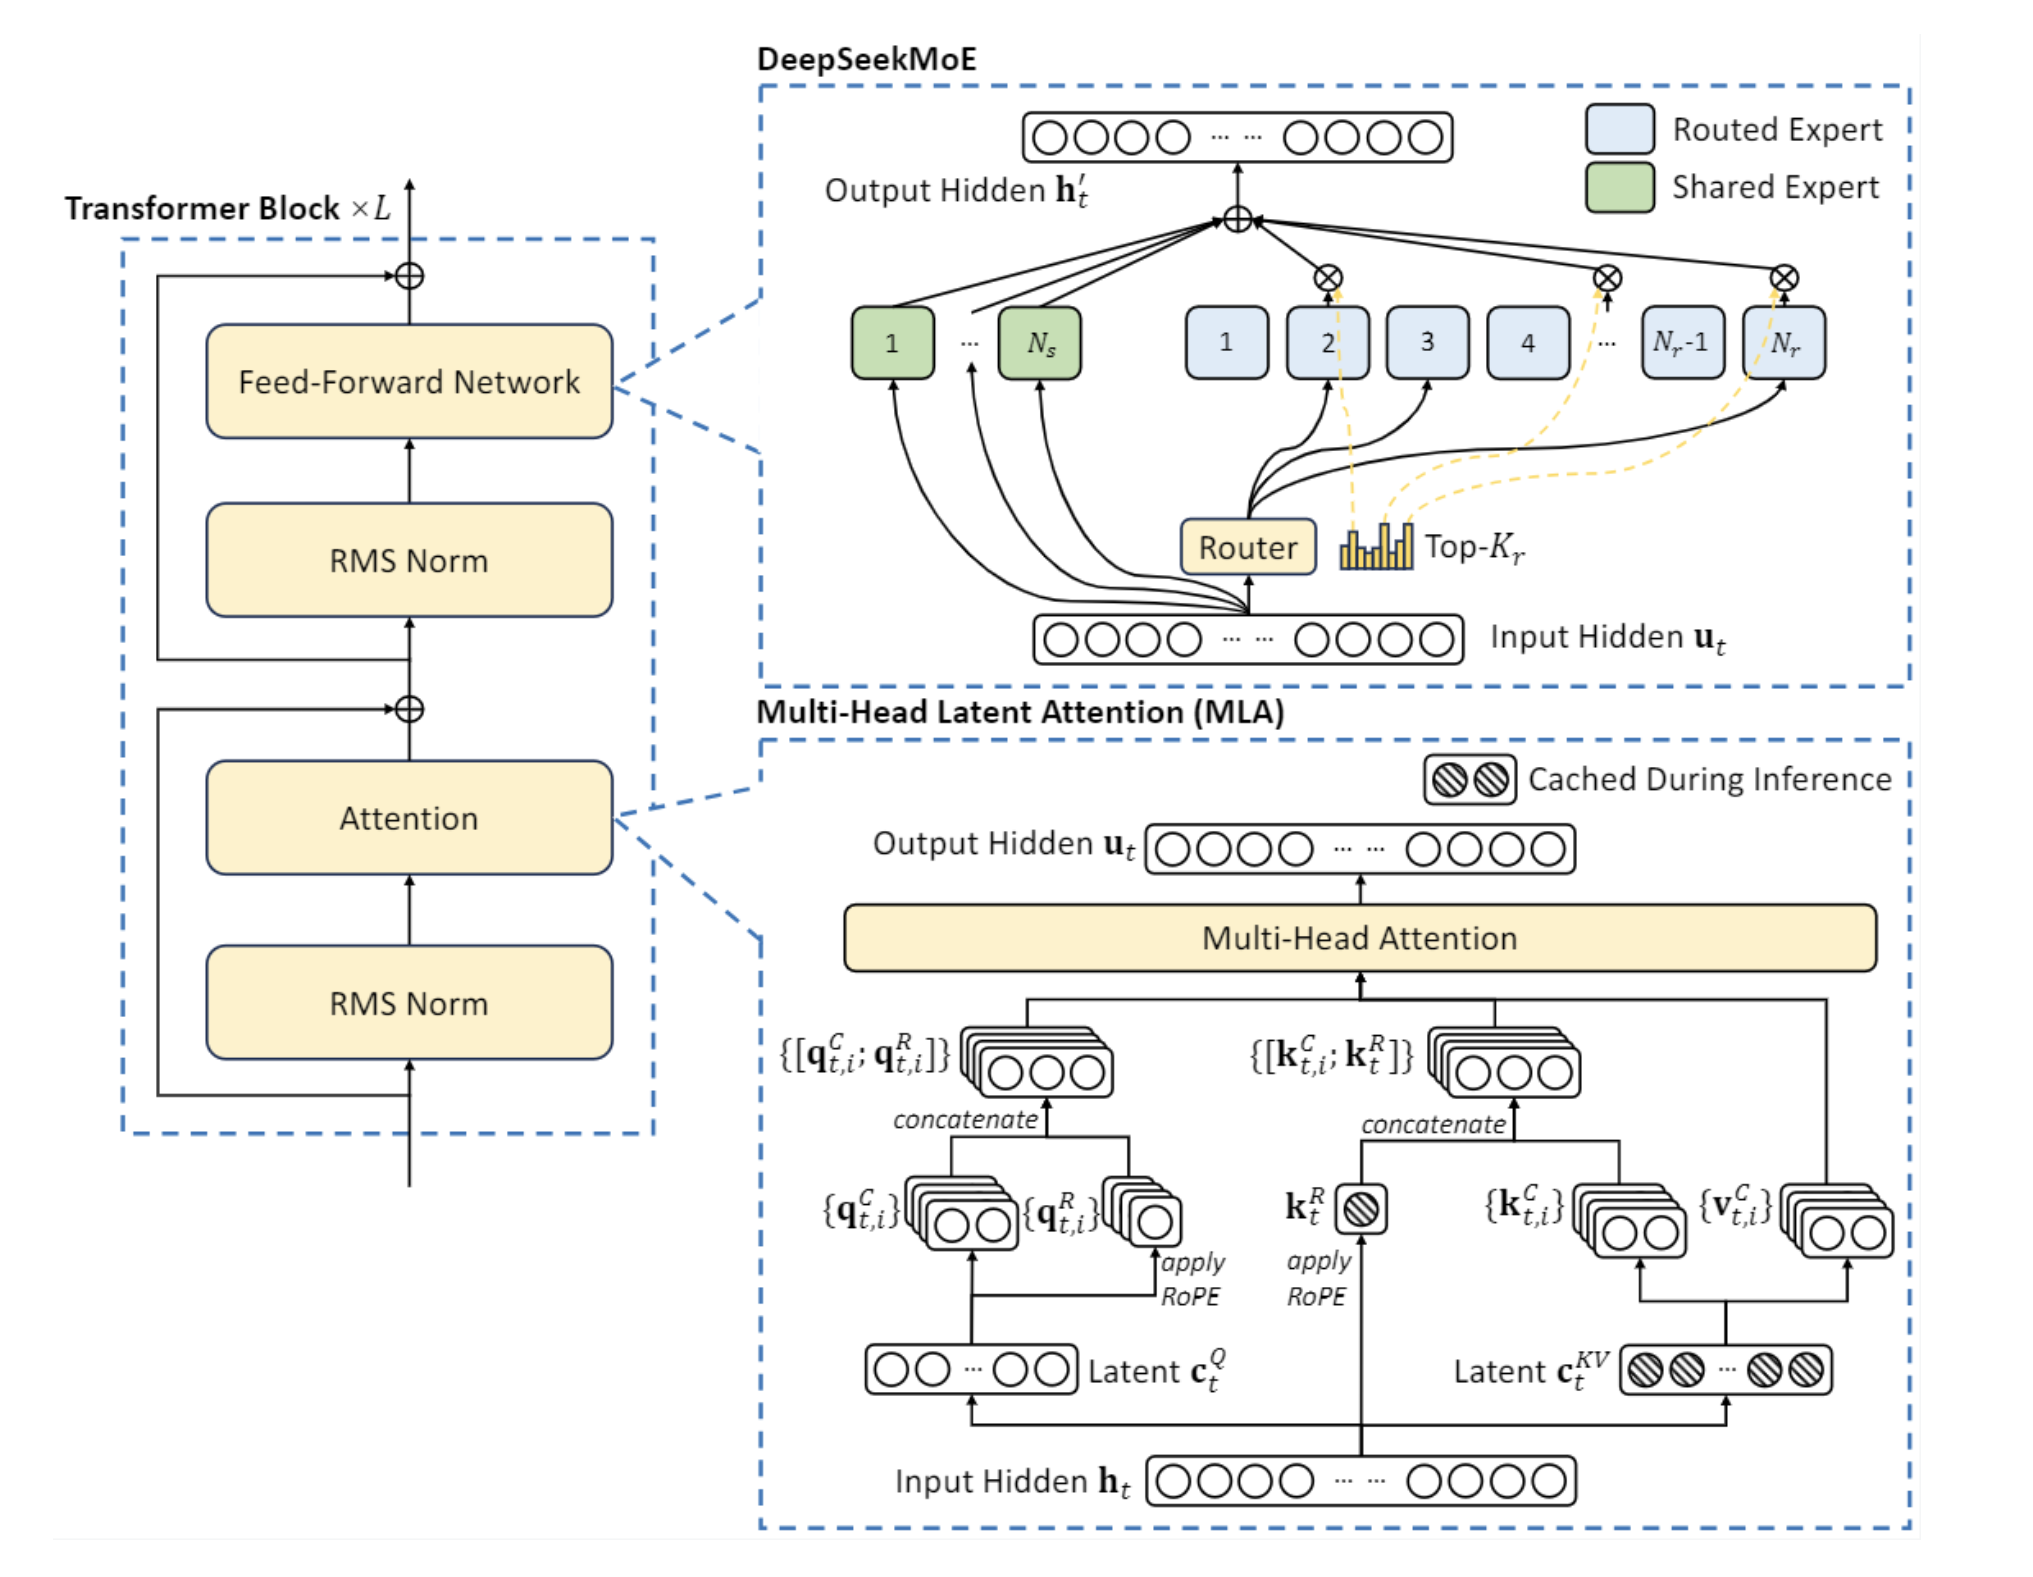

In [ ]:
from IPython.display import Image, display
display(Image(filename="../markdown/assets/deepseek-v3-model-architecture.png"))

## Deepseek Moe

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataclasses import dataclass


class DeepseekMoe(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.router_moe = SparseMoe(config)
        self.config = config
        self.experts = nn.ModuleList([
            BaseExpert(config.hidden_dim,config.hidden_dim) for _ in range(config.expert_num)
        ])

    def forward(self,x):
        experts_list = torch.stack([
            experts(x) for experts in self.experts
        ],dim=0)

        # 拼接了第一个维度，求和的时候需要去除掉
        experts_data = experts_list.sum(dim=0,keepdim=False)

        SparseMoe_data , logistics = self.router_moe(x)
        
        # shape (batch,seq,hidden_dim)
        final_data = experts_data + SparseMoe_data

        return final_data,logistics


def test_share_expert_moe():
    x = torch.rand(2, 4, 16)
    config = Moeconfig(16, 2, 2)
    share_expert_moe = DeepseekMoe(config)
    out = share_expert_moe(x)
    print(out[0].shape, out[1].shape)


test_share_expert_moe()

torch.Size([2, 4, 16]) torch.Size([8, 2])


In [ ]:
test = torch.tensor([[0,1],
                    [4,3],
                    [5,4],
                    [0,0]])
print(test.shape)
test = test.reshape(2,-1)
print(test)
idx,topx = torch.where(test)
idx,topx

hot = torch.tensor([[1,0],[0,0]])

torch.Size([4, 2])
tensor([[0, 1, 4, 3],
        [5, 4, 0, 0]])


(tensor([0, 0, 0, 1, 1]), tensor([1, 2, 3, 0, 1]))

In [ ]:
import torch

routing_probs = torch.tensor([
    [0.1, 0.4, 0.3, 0.2],  # 第一个 token 的 4 个专家概率
    [0.2, 0.1, 0.5, 0.2],  # 第二个 token 的 4 个专家概率
])  # shape = (2, 4), 假设 batch_size * seq_len = 2, expert_number = 4
# (4,2)
top_k = 2

router_weights, selected_experts = torch.topk(routing_probs, top_k, dim=-1)

print("router_weights:\n", router_weights)
print("selected_experts:\n", selected_experts)
print(routing_probs.shape,selected_experts.shape)

mask = F.one_hot(selected_experts,4)

print("未反转的矩阵:# shape(batch * seq,topx,expert_num)\n",mask)
mask = mask.permute(2,1,0)

print("原始反转矩阵:# shape(expert_num,topx,batch * seq)\n",mask)
choose = mask[1]
print("第二个专家的矩阵:(topx,batch * seq)\n",choose)
idx, topx = torch.where(choose)
print(idx,topx)
#(2,2)

router_weights:
 tensor([[0.4000, 0.3000],
        [0.5000, 0.2000]])
selected_experts:
 tensor([[1, 2],
        [2, 0]])
torch.Size([2, 4]) torch.Size([2, 2])
未反转的矩阵:# shape(batch * seq,topx,expert_num)
 tensor([[[0, 1, 0, 0],
         [0, 0, 1, 0]],

        [[0, 0, 1, 0],
         [1, 0, 0, 0]]])
原始反转矩阵:# shape(expert_num,topx,batch * seq)
 tensor([[[0, 0],
         [0, 1]],

        [[1, 0],
         [0, 0]],

        [[0, 1],
         [1, 0]],

        [[0, 0],
         [0, 0]]])
第二个专家的矩阵:(topx,batch * seq)
 tensor([[1, 0],
        [0, 0]])
tensor([0]) tensor([0])


In [ ]:
test = torch.tensor([1,2,3])
b = torch.tensor([2])
a = b*test
b.shape,test.shape,

(torch.Size([1]), torch.Size([3]))